# <span style='color: red; font-size: 3rem'>DRAFT</span>

# WHO, Global Health Observatory - Data access and geospatial plotting
### Steven Fowler <a id='headerlink' href="https://stevenafowler.github.io/diablothewonderdog/" target="_blank">(see more projects here)</a>

<img id = 'headerimage' src="assets/images/World_Health_Organization_Logo.svg.png">

The Global Health Observatory (GHO) is the World Health Organisation's (WHO) gateway to share data on global health. It is structured into categories of indicators (3043 at time of writing) that describe health statistics. They generally all have dimensions of time (year) and country, some have additional dimensions for example 'Age Group', 'Sex', 'Severity.

This report will look at how to access this data and give examples of geospatial charts that can be generated.

## What I did
The following show how python can be used to access and navigate the WHO's database thought their OAPI.
Finally, there are some example geospatial plots of the WHO data in both static and interactive forms.

## Why I did it
The WHO provides an interesting and robust set of data that can be used for investigating global health trends. This investigation was done to demonstrate how this information can be accessed and show examples of how this data can be illustrated. This opening the possibility for focused studies. 

## What I learnt
The WHO's OAPI facilitates easy access to its databases, which require minimal data processing.

## Accessing the GHO

The GHO can be accessed through the WHO's OData API ([link](https://www.who.int/data/gho/info/gho-odata-api)). Using Python's `Requests` HTTP library makes accessing this data a simple task.

The following function will return a dataframe based on a requested URL.

In [2]:

import requests as req
import pandas as pd
# from itables import show
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Javascript

def get_df_from_GHO_URL(URL, record_path = ['value']):
    """Return dataframe based on URl from GHO OData API.

    Args:
        URL (string): URL @ GHO OData API
        record_path (list, optional): Returned data is mostly nested JSON, record-path = ['value'] will return data. Defaults to ['value'].

    Returns:
        dataframe: pandas DF of data from URL, based on nested JSON.
    """
    response = req.get(URL)     # Download data into dictionary

    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

    # Return dataframe
    return pd.json_normalize(data, record_path=record_path)

## Structure of available data

The data sets provided by the GHO are divided into indicators (3043 at the time of writing), for example:

* Number of people dying from HIV-related causes (ID: HIV_0000000006)
* Number of laboratory scientists (ID: HRH_13)
* Penalties for drink driving (ID: SA_0000001726)

Indicators have a primary value that reflects upon the indicator. In general, this primary value has dimensions of country and year, and some indicators have additional indicators for example:

* Patient type
* Antibiotic
* Pregnancy status

### Accessing a list of indicators

A list of indicators can be found here: [https://ghoapi.azureedge.net/api/Indicator](https://ghoapi.azureedge.net/api/Indicator).

For example:

In [3]:
INDICATOR_LIST_URL = "https://ghoapi.azureedge.net/api/Indicator"

indicatorList = get_df_from_GHO_URL(INDICATOR_LIST_URL)

print(f"\nTotal number of indicators: {len(indicatorList)}.\n")
# print(indicatorList.head(n = 10))
indicatorList[0:10]
# show(indicatorList)


Total number of indicators: 3047.



,IndicatorCode,IndicatorName,Language
0,HIV_0000000001,Estimated number of people (all ages) living w...,EN
1,HIV_0000000026,Number of new HIV infections,EN
2,HRH_06,Number of community health workers,EN
3,HRH_07,Number of traditional birth attendants,EN
4,EMFLIMITPOWERDENSITY,Power density (W/m^2),EN
5,EMFSAR,Specific absorption rate (SAR) (W/kg),EN
6,EMFSTATUS,Legislative status,EN
7,EQ_OVERWEIGHTADULT,Prevalence of overweight and obesity,EN
8,FINPROTECTION_CATA_TOT_10_LEVEL_MILLION,Population with household spending on health g...,EN
9,FINPROTECTION_CATA_TOT_10_LEVEL_SH,Population with household spending on health g...,EN


### Accessing list of dimensions

A list of dimensions can be found here: [https://ghoapi.azureedge.net/api/Dimension](https://ghoapi.azureedge.net/api/Dimension).

And the an index for the dimension values can be found here:  [https://ghoapi.azureedge.net/api/DIMENSION/COUNTRY/DimensionValues](https://ghoapi.azureedge.net/api/DIMENSION/COUNTRY/DimensionValues).

For example:

In [4]:
DIMENSION_AVAILABLE_URL = "https://ghoapi.azureedge.net/api/Dimension"

dimensionsAvailable = get_df_from_GHO_URL(DIMENSION_AVAILABLE_URL)

print(f"\nTotal number of dimensions: {len(dimensionsAvailable)}.\n")
# print(dimensionsAvailable.head(n = 10))
dimensionsAvailable[1:10]
# show(dimensionsAvailable)


Total number of dimensions: 192.



,Code,Title
1,AGEGROUP,Age Group
2,ALCOHOLTYPE,Beverage Types
3,AMRGLASSCATEGORY,AMR GLASS Category
4,ANTIBIOTIC,Antibiotic
5,ARCHIVE,Archive date
6,ASSISTIVETECHBARRIER,Barriers to accessing assistive products
7,ASSISTIVETECHFUNDING,Funding for assistive tech products
8,ASSISTIVETECHPRODUCT,Assistive technology product
9,ASSISTIVETECHSATIACTIVITY,Satisfaction with assistive products for diffe...


In [5]:
DIMENSION_VALUES_URL = "https://ghoapi.azureedge.net/api/DIMENSION/COUNTRY/DimensionValues"

dimensionValues = get_df_from_GHO_URL(DIMENSION_VALUES_URL)

# print(dimensionValues.head(n = 5))
dimensionValues[0:5]
# show(dimensionValues)

,Code,Title,Dimension,ParentDimension,ParentCode,ParentTitle
0,ABW,Aruba,COUNTRY,REGION,AMR,Americas
1,AFG,Afghanistan,COUNTRY,REGION,EMR,Eastern Mediterranean
2,AGO,Angola,COUNTRY,REGION,AFR,Africa
3,AIA,Anguilla,COUNTRY,REGION,AMR,Americas
4,ALB,Albania,COUNTRY,REGION,EUR,Europe


# Example data - "Healthy life expectancy at birth (years)"

As an example indicator, `Healthy life expectancy at birth (years)` is the ['Average number of years that a person can expect to live in “full health” from birth'](https://data.who.int/indicators/i/48D9B0C/C6484D). To access the data we need the associated indicator code. Then the data can be requested as was done in the above examples.

In [6]:
# Find indicator code
indicatorList[indicatorList.IndicatorName.str.contains("life expectancy", case=False)]

,IndicatorCode,IndicatorName,Language
2020,WHOSIS_000007,Healthy life expectancy (HALE) at age 60 (years),EN
2024,WHOSIS_000015,Life expectancy at age 60 (years),EN
2040,WHOSIS_000002,Healthy life expectancy (HALE) at birth (years),EN
2056,WHOSIS_000001,Life expectancy at birth (years),EN


In [7]:
# Download data and cast to DF
INDICATOR_DATA = "https://ghoapi.azureedge.net/api/"
indicator_code = "WHOSIS_000002"

whosis_000002_data = get_df_from_GHO_URL(INDICATOR_DATA + indicator_code)
whosis_000002_data.dtypes

Id                      int64
IndicatorCode          object
SpatialDimType         object
SpatialDim             object
ParentLocationCode     object
TimeDimType            object
ParentLocation         object
Dim1Type               object
TimeDim                 int64
Dim1                   object
Dim2Type               object
Dim2                   object
Dim3Type               object
Dim3                   object
DataSourceDimType      object
DataSourceDim          object
Value                  object
NumericValue          float64
Low                   float64
High                  float64
Comments               object
Date                   object
TimeDimensionValue     object
TimeDimensionBegin     object
TimeDimensionEnd       object
dtype: object

From the above table is can be seen that are 4 numeric dimensions:

* `TimeDim` - The year associated with the value
* `NumericValue` - The age (number of years) of healthy life expectancy
* `Low`, `High` - Confidence interval associated with `NumericValue`

There are also geographic dimensions, primarily `SpatialDim` which is the country code that is defined in the dimension values listed above. An additional dimension in this dataset is `Sex`, which is captured under `Dim1`.

## Example geospatial chart - "Healthy life expectancy at birth (years)"

The following example uses WHO indicator `WHOIS_000002` - "Healthy life expectancy at birth (years)". Plotted on a geospatial chart illustrates the lower life expectancy in the mid to southern africa region, while Japan stands out as a clear high life expectancy.

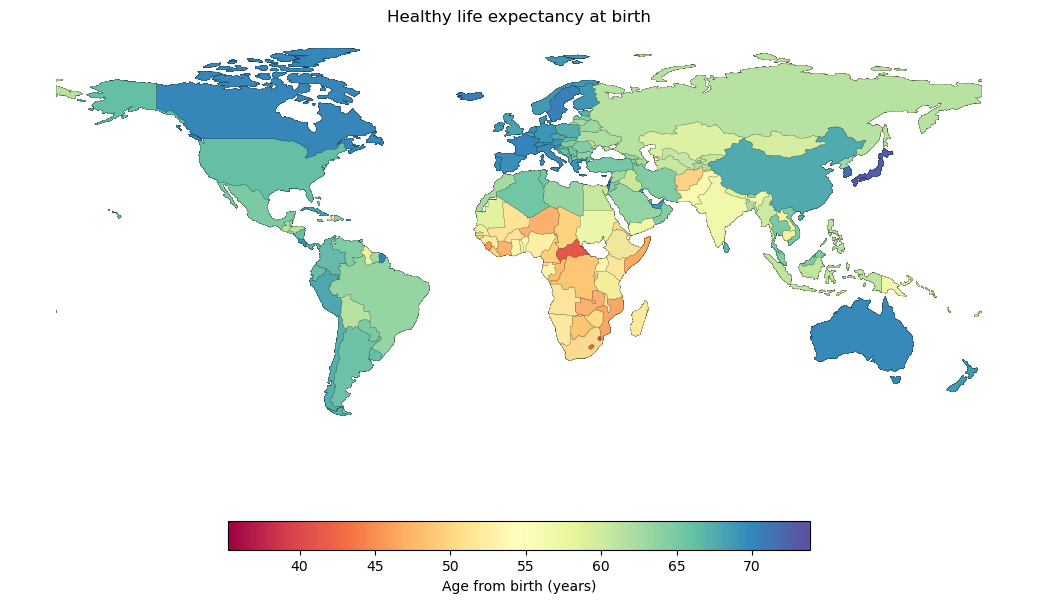

In [8]:
# Get world map geospatial data and 'join it' to WHO DF
# Convert DF to geoDF with defined 'geometry' column
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
worldMap = gpd.read_file(url)
worldMap['SpatialDim'] = worldMap['ADM0_A3']

whosis_000002_GeoData = pd.merge(whosis_000002_data, worldMap, on='SpatialDim', how='left')
whosis_000002_GeoData = gpd.GeoDataFrame(whosis_000002_GeoData)
whosis_000002_GeoData = whosis_000002_GeoData.set_geometry('geometry')

# Plot data
fig, ax = plt.subplots(figsize=(15,7.5))

# Plot world map as base layer
whosis_000002_GeoData[whosis_000002_GeoData.Dim1 =='SEX_BTSX'].plot(ax=ax, 
                                                                    column='NumericValue', 
                                                                    cmap='Spectral', 
                                                                    edgecolor='black', 
                                                                    linewidth=0.1,
                                                                    alpha=0.5, 
                                                                    legend=True,
                                                                    legend_kwds={
                                                                        'label': 'Age from birth (years)', 
                                                                        'orientation': 'horizontal',
                                                                        'shrink': 0.5                                                                        }
                                                                    )

ax.set_axis_off()
plt.title("Healthy life expectancy at birth")
plt.show()

## Interactive plot

An example of an interactive geospatial plot can be found here: [Interactive geospatial chart](genericPlot.html).

